### Goal
To use deep q-learning to make a bot that plays Secret Hitler.

In [1]:
import random
from numpy.random import permutation
from numpy.random import choice
import numpy as np

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
INPUT_SIZE = 60
class input_maker():
    @staticmethod
    def roles(seat, rs):
        inpts = np.zeros(INPUT_SIZE)
        my_role = rs[seat]
        if my_role in [0, 2]:
            inpts[seat] = 1
            return inpts
        
        inpts[:7][np.array(rs) >= my_role] = 1
        return inpts
    
    @staticmethod
    def cabinet(pres, chance):
        inpts = np.zeros(INPUT_SIZE)
        inpts[7+pres] = 1
        inpts[14+chance] = 1
        return inpts
    
    @staticmethod
    def votes(vs):
        inpts = np.zeros(INPUT_SIZE)
        inpts[21:28] = np.array(vs) * 2 - 1 # -1 for nein, 1 for ja, better for the NN
        return inpts
    
    @staticmethod
    def kill(kill):
        inpts = np.zeros(INPUT_SIZE)
        inpts[28 + kill] = 1
        return inpts
    
    @staticmethod
    def se(se):
        inpts = np.zeros(INPUT_SIZE)
        inpts[35 + se] = 1
        return inpts
    
    @staticmethod
    def inv(i, role):
        # For everyone
        inpts = np.zeros(INPUT_SIZE)
        inpts[42 + i] = 1
        inpts[49 + role] = 1 # role is 0 for lib, 1 for fas/hitty
        return inpts
    
    @staticmethod
    def inv_card(i, card):
        # For pres (and it'll also see the next regular inv inpts)
        inpts = np.zeros(INPUT_SIZE)
        inpts[42 + i] = 1
        inpts[51 + card] = 1
        return inpts
    
    @staticmethod
    def claim_cards(pres_claim, chance_claim, policy_passed):
        inpts = np.zeros(INPUT_SIZE)
        inpts[53:56] = np.array(pres_claim)*2 - 1
        inpts[56:58] = np.array(chance_claim)*2 - 1
        inpts[58 + policy_passed] = 1
        return inpts

In [3]:
# This is if I want it to do more than just a qtable, but for now
# I will just use a qtable.
OUTPUT_SIZE = 100
class output_decoder():
    @staticmethod
    def chance(outputs):
        probs = F.softmax(torch.tensor(outputs[:7])).numpy()
        probs /= sum(probs)
        seats = list(range(7))
        permutation = choice(seats, 7, p=probs, replace=False)
        return permutation
    
    @staticmethod
    def vote(outputs):
        probs = F.softmax(torch.tensor(outputs[7:9])).numpy()
        probs /= sum(probs)
        votes = [0, 1]
        v = choice(votes, 1, p=probs)
        return v
    
    @staticmethod
    def pres_pick(outputs):
        pass

In [4]:
class Game():
    def __init__(self, players, roles=None, verbose=0):
        self.verbose = verbose
        self.players = permutation(players)
        if roles is None:
            roles = permutation([0, 0, 0, 0, 1, 1, 2])
            
        if self.verbose >= 1:
            print(*map(lambda x: ["Lib", "Fas", "Hit"][x], roles))
        
        for player in self.players:
            player.verbose = self.verbose
            
        self.roles = roles
        self.lib_count = 0
        self.fas_count = 0
        self.last_pres = -1
        self.last_chance = -1
        self.pres = 0
        self.chance = 0
        self.on_se = False
        self.tracker = 0
        
        self.dead = [False for i in range(7)]
        
        for i, player in enumerate(self.players):
            player.start_game(roles[i], i)
            player.feed_inputs(input_maker.roles(i, roles))
            
        self.deck = permutation([0 for i in range(6)] + [1 for i in range(11)]).tolist()
        
    def play(self):
        winning_team = None
        while winning_team is None:
            winning_team = self.play_turn()
        if winning_team == 1:
            self.winners = [player for i, player in enumerate(self.players) if self.roles[i] == 0]
        else:
            self.winners = [player for i, player in enumerate(self.players) if self.roles[i] != 0]
        for i, player in enumerate(self.players):
            player.end_game(winning_team)
        
    def filter_(self, lis):
        return [0 if self.dead[i] else e for i, e in enumerate(lis)]
    
    def next_pres(self, se_pres=None):
        if self.on_se:
            if se_pres is None:
                self.pres, self.last_pres = (self.last_pres + 1)%7, self.pres
                self.on_se = False
            else:
                self.pres, self.last_pres = se_pres, self.pres
        else:
            self.pres, self.last_pres = (self.pres + 1)%7, self.pres
        self.last_chance = self.chance
        
        if len(self.deck) < 3:
            self.deck = permutation([0 for i in range(6 - self.lib_count)] + [1 for i in range(11 - self.fas_count)]).tolist()
        
    def play_turn(self):
        chance_picks = self.players[self.pres].pick_chance()
        # Find legal chancellor pick
        i = 0
        chance = chance_picks[i]
        while chance in [self.last_pres, self.last_chance, self.pres] or self.dead[chance]:
            i += 1
            chance = chance_picks[i]
            
        self.chance = chance
        
        if self.verbose >= 1:
            print(f"{self.pres+1} has chosen {self.chance+1} as chancellor.")
        
        # Feed cabinet to players
        inpts = input_maker.cabinet(self.pres, self.chance)
        for player in self.players:
            player.feed_inputs(inpts)
            
        # Tally votes & feed them to players
        votes = self.filter_([player.vote() for player in self.players])
        
        if self.verbose >= 2:
            print("Votes:", *list(map(lambda x: "Ja" if x else "Nein", votes)))
            
        inpts = input_maker.votes(votes)
        for player in self.players:
            player.feed_inputs(inpts)
        
        # Check if vote passed
        if sum(votes) < 4:
            # Cabinet didn't passs
            self.tracker += 1
            if self.verbose >= 2:
                print("Failed to pass.")
            if self.tracker == 3:
                # Top deck
                card = self.deck[0]
                self.deck = self.deck[1:]
                if card == 1:
                    self.fas_count += 1
                else:
                    self.lib_count += 1
                if self.verbose >= 1:
                    print(f"A {'fascist' if card else 'liberal'} policy is top decked."
                         )
                    print(f"Current tally: L{self.lib_count}, F{self.fas_count}")
                if self.lib_count == 5:
                    return 1
                elif self.fas_count == 6:
                    return -1
                self.tracker = 0
            
            self.next_pres()
            return
        
        # Cabinet passed
        self.tracker = 0
        if self.verbose >= 2:
            print("Cabinet passes.")
            
        if self.fas_count >= 3 and self.roles[chance] == 2:
            # Hitler was elected, fas win.
            if self.verbose >= 1:
                print("Hitler was elected chancellor. Fascist win.")
            return -1
        
        # Grab top three cards off of deck
        cards = sorted(self.deck[:3])
        self.deck = self.deck[3:]
        
        # President discards one
        discard = self.players[self.pres].pick_card_pres(cards[:])
        pres_claim = self.players[self.pres].claim_cards_pres(cards[:])
        
        if self.verbose >= 1:
            print(f"President ({self.pres+1}) claims {''.join(map(lambda x: 'R' if x else 'B', pres_claim))} (sees {''.join(map(lambda x: 'R' if x else 'B', cards))})"
                 )
        cards.remove(discard)
        # Chancellor enacts one
        enacted = self.players[self.chance].pick_card_chance(cards[:])
        chance_claim = self.players[self.chance].claim_cards_chance(cards[:])
        if self.verbose >= 1:
            print(f"Chancellor ({self.chance+1}) claims {''.join(map(lambda x: 'R' if x else 'B', chance_claim))} (sees {''.join(map(lambda x: 'R' if x else 'B', cards))})"
                 )
        if enacted == 0:
            self.lib_count += 1
        else:
            self.fas_count += 1
        
        if self.verbose >= 1:
            print(f"{'Fascist' if enacted else 'Liberal'} policy enacted."
                 )
            
        if self.verbose >= 1:
            print(f"Current tally: L{self.lib_count}, F{self.fas_count}")
        
        # Share claims with the players
        inpts = input_maker.claim_cards(pres_claim, chance_claim, enacted)
        for player in self.players:
            player.feed_inputs(inpts)
            
            
        picking_se = False
        if enacted == 0:
            if self.lib_count == 5:
                # Libs win
                return 1
        else:
            if self.fas_count == 2:
                # inv power
                inv = self.players[self.pres].pick_inv()
                role = 0 if self.roles[inv] == 0 else 1
                inv_claim = self.players[self.pres].claim_inv(role)
                if self.verbose >= 1:
                    print(f"{self.pres+1} investigates {inv + 1} as {'fascist' if inv_claim else 'liberal'}."
                         )
                # feed inv claim to all players
                inpts = input_maker.inv(inv, role)
                for player in self.players:
                    player.feed_inputs(inpts)

            elif self.fas_count == 3:
                # se power
                se = self.players[self.pres].pick_se()
                if self.verbose >= 1:
                    print(f"{self.pres+1} special elects {se+1}.")

                # feed inputs
                inpts = input_maker.se(se)
                for player in self.players:
                    player.feed_inputs(inpts)

                self.on_se = True
                picking_se = True
                self.next_pres(se_pres=se)

            elif self.fas_count == 4 or self.fas_count == 5:
                # kill power
                kill = self.players[self.pres].pick_kill()
                i = 0
                k = kill[i]
                while k == self.pres or (self.roles[self.pres] > 0 and self.roles[k] == 2):
                    i += 1
                    k = kill[i]
                self.dead[k] = True
                if self.verbose >= 1:
                    print(f"{self.pres+1} kills {k+1}.")
                    
                if self.roles[k] == 2:
                    # Hitler is shot, libs win
                    if self.verbose >= 1:
                        print("Hitler was shot, liberals win.")
                    return 1
            elif self.fas_count == 6:
                # Fas win
                return -1
        
        if not picking_se:
            self.next_pres()
        
        return

In [7]:
class RandomPlayerOld():
    def __init__(self):
        self.wins = 0
        self.games_played = 0
        
    def start_game(self, role, seat):
        self.role = role
        self.seat = seat
        
    def feed_inputs(self, inputs):
        pass
        
    def vote(self):
        # 1 = ja, 0 = nein
        return random.choice([0, 1])
    
    def pick_kill(self):
        # priority of which person to kill first if possible
        return permutation(range(7))
    
    def pick_chance(self):
        # priority of which person to pick first if possible
        return permutation(range(7))
    
    def pick_se(self):
        seat = random.choice(range(7))
        while seat == self.seat:
            seat = random.choice(range(7))
        return seat
    
    def pick_inv(self):
        seat = random.choice(range(7))
        while seat == self.seat:
            seat = random.choice(range(7))
        return seat
    
    def claim_inv(self, role):
        # 0 = lib, 1 = fas
        if self.role == 0:
            return role
        return random.choice([0, 1])
    
    def pick_card_pres(self, cards):
        # Pick a card for the president to discard
        # 0 = lib, 1 = fas
        if self.role == 0:
            if 1 in cards: # discard any fas if possible.
                return 1
            return 0
        else: # discard liberal if I'm fas... I know this isn't always optimal, but I don't have a better method yet.
            self.card_claim = sorted(cards)
            return random.choice(cards)
    
    def pick_card_chance(self, cards):
        # Pick a card to enact as chancellor
        if self.role == 0:
            if 0 in cards:
                return 0
            return 1
        else:
            self.card_claim = sorted(cards)
            return random.choice(cards)
    
    def claim_cards_pres(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def claim_cards_chance(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def end_game(self, winning_team):
        self.games_played += 1
        if winning_team > 0 and self.role == 0:
            self.wins += 1
        elif winning_team < 0 and self.role > 0:
            self.wins += 1

In [8]:
class RandomPlayer():
    def __init__(self):
        self.wins = 0
        self.games_played = 0
        
    def start_game(self, role, seat):
        self.role = role
        self.seat = seat
        
    def feed_inputs(self, inputs):
        pass
        
    def vote(self):
        # 1 = ja, 0 = nein
        return random.choice([0, 1])
    
    def pick_kill(self):
        # priority of which person to kill first if possible
        return permutation(range(7))
    
    def pick_chance(self):
        # priority of which person to pick first if possible
        return permutation(range(7))
    
    def pick_se(self):
        seat = random.choice(range(7))
        while seat == self.seat:
            seat = random.choice(range(7))
        return seat
    
    def pick_inv(self):
        seat = random.choice(range(7))
        while seat == self.seat:
            seat = random.choice(range(7))
        return seat
    
    def claim_inv(self, role):
        # 0 = lib, 1 = fas
        if self.role == 0:
            return role
        return random.choice([0, 1])
    
    def pick_card_pres(self, cards):
        # Pick a card for the president to discard
        # 0 = lib, 1 = fas
        if self.role == 0:
            if 1 in cards: # discard any fas if possible.
                return 1
            return 0
        else: # discard liberal if I'm fas... I know this isn't always optimal, but I don't have a better method yet.
            if 0 in cards:
                self.card_claim = sorted(cards)[1:] + [1]
                return 0
            self.card_claim = sorted(cards)
            return 1
    
    def pick_card_chance(self, cards):
        # Pick a card to enact as chancellor
        if self.role == 0:
            if 0 in cards:
                return 0
            return 1
        else:
            if 1 in cards:
                self.card_claim = [1, 1]
                return 1
            self.card_claim = [0, 0]
            return 0
    
    def claim_cards_pres(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def claim_cards_chance(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def end_game(self, winning_team):
        self.games_played += 1
        if winning_team > 0 and self.role == 0:
            self.wins += 1
        elif winning_team < 0 and self.role > 0:
            self.wins += 1

In [9]:
class QNN(nn.Module):
    # Q table for NNPlayer
    # Uses a RNN (GRU layers).
    def __init__(self, input_size, hidden_size, output_size, n_layers=5, dropout=0):
        super(QNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_size, hidden_size, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, action, hidden):
        output = action.unsqueeze(0)
        if len(output.shape) == 2:
           output.unsqueeze_(0)
        output, hidden = self.gru(output, hidden)
        output = self.tanh(self.linear(output))
        return output, hidden
    
    def init_hidden(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda()

In [10]:
class SHDataset(Dataset):
    def __init__(self, max_length=1000):
        self.max_length = max_length
        self.lis = []
        self.len = 0
        self.idx = 0

    def __len__(self):
        return len(self.lis)
    
    def append(self, item):
        if self.len == self.max_length:
            self.lis[self.idx] = item
            self.idx += 1
            self.idx %= self.max_length
        else:
            self.lis.append(item)
            self.len += 1

    def __getitem__(self, idx):
        return self.lis[idx]

In [11]:
class NNPlayerOld():
    def __init__(self, lr=1e-4, r=0.999):
        self.qnn = QNN(input_size=INPUT_SIZE, hidden_size=20, output_size=1).cuda()
        self.lr = lr
        self.r = r
        
        self.data = SHDataset()
        self.criterion = nn.MSELoss()
        self.optim = optim.SGD(self.qnn.parameters(), lr=lr, weight_decay=0e-3)
        self.do_random = 0
        self.random_decrease_rate = 1e-3
        self.random_player = RandomPlayer()
        
        self.wins = 0
        self.games_played = 0
        
    def start_game(self, role, seat):
        self.role = role
        self.seat = seat
        self.inv_seat = None
        self.hidden = self.qnn.init_hidden()
        self.reward = 0
        self.inputs = torch.zeros(INPUT_SIZE).cuda().float()
        self.q = 0
        
        self.random_player.start_game(role, seat)
        
    def feed_inputs(self, inputs):
        inputs = torch.tensor(inputs, device='cuda').float()
        h = self.hidden.detach().clone()
        self.q, self.hidden = self.qnn.forward(inputs, self.hidden)
        r = self.reward + self.q*self.r
        self.data.append([h, r, inputs])
        self.inputs = inputs
        
    def end_game(self, winning_team):
        self.games_played += 1
        if winning_team > 0 and self.role == 0:
            self.wins += 1
        elif winning_team < 0 and self.role > 0:
            self.wins += 1
        
        if winning_team > 0 and self.role == 0:
            self.reward = 1
        elif winning_team < 0 and self.role == 0:
            self.reward = -1
        elif winning_team > 0 and self.role > 0:
            self.reward = -1
        else:
            self.reward = 1
        h = self.hidden.detach().clone()
        r = self.reward + self.q*self.r
        self.data.append([h, r, self.inputs])
        
    def feed_inputs_(self, inputs):
        # returns output without changing hidden state
        inputs = torch.tensor(inputs, device='cuda').float()
        q, _ = self.qnn.forward(inputs, self.hidden)
        return q
        
    def vote(self):
        # 1 = ja, 0 = nein
        if random.random() < self.do_random:
            return self.random_player.vote()
        
        ja_q = self.feed_inputs_(input_maker.votes([1, 1, 1, 1, 1, 1, 1]))
        nein_q = self.feed_inputs_(input_maker.votes([0, 0, 0, 0, 0, 0, 0]))
        probs = F.softmax(torch.tensor([ja_q, nein_q])).numpy()
        probs /= probs.sum()
        return choice([1, 0], p=probs)
    
    def pick_kill(self):
        # priority of which person to kill first if possible
        if random.random() < self.do_random:
            return self.random_player.pick_kill()
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.kill(seat))
            qs.append(q)
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        if self.verbose >= 3:
            print(probs)
        return choice(range(7), 7, p=probs, replace=False)
    
    def pick_chance(self):
        # priority of which person to pick first if possible
        if random.random() < self.do_random:
            return self.random_player.pick_chance()
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.cabinet(self.seat, seat))
            qs.append(q)
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        return choice(range(7), 7, p=probs, replace=False)
    
    def pick_se(self):
        if random.random() < self.do_random:
            return self.random_player.pick_se()
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.se(seat))
            qs.append(q)
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        seat = choice(range(7), p=probs)
        while seat == self.seat:
            seat = choice(range(7), p=probs)
        return seat
    
    def pick_inv(self):
        if random.random() < self.do_random:
            self.inv_seat = self.random_player.pick_inv()
            return self.inv_seat
        qs = []
        for seat in range(7):
            q1 = self.feed_inputs_(input_maker.inv_card(seat, 0))
            q2 = self.feed_inputs_(input_maker.inv_card(seat, 1))
            q = q1*4/7 + q2*3/7
            qs.append(q)
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        seat = choice(range(7), p=probs)
        while seat == self.seat:
            seat = choice(range(7), p=probs)
        self.inv_seat = seat
        return seat
    
    def claim_inv(self, role):
        # 0 = lib, 1 = fas
        if random.random() < self.do_random:
            return self.random_player.claim_inv(role)
        
        if self.role == 0:
            # Force it to tell the truth if liberal.
            return role
        
        qs = []
        for claim in [0, 1]:
            q = self.feed_inputs_(input_maker.inv(self.inv_seat, role))
            qs.append(q)
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        claim = choice([0, 1], p=probs)
        while claim == self.seat:
            claim = choice([0, 1], p=probs)
        return claim
    
    
    # Force liberals to always discard fas and enact liberal policies.
    # Fascists should pick to try to be clever though.
    def pick_card_pres(self, cards):
        # Pick a card for the president to discard
        # 0 = lib, 1 = fas
        if self.role == 0:
            if 1 in cards: # discard any fas if possible.
                return 1
            return 0
        else: # discard liberal if I'm fas... I know this isn't always optimal, but I don't have a better method yet.
            if 0 in cards:
                self.card_claim = sorted(cards)[1:] + [1]
                return 0
            self.card_claim = sorted(cards)
            return 1
        
        if cards == [1, 1, 1]:
            # we have RRR
            self.card_claim = cards[:]
            return 1
        elif cards == [0, 0, 0]:
            # we have BBB
            self.card_claim = cards[:]
            return 0
        
        # What claim should be if we remove a liberal
        rmv_lib = cards[:]
        rmv_lib.remove(0)
        rmv_lib.append(1)
        rmv_lib.sort()
        
        # q value for this action:
        inpts = input_maker.claim_cards(rmv_lib, rmv_lib[:2], rmv_lib[0])
        q_rmv_lib = self.feed_inputs_(inpts)
        
        # What claim should be if we remove a fascist
        rmv_fas = cards[:]
        
        # q value for removing a fas card
        inpts = input_maker.claim_cards(rmv_fas, rmv_fas[:2], rmv_fas[0])
        q_rmv_fas = self.feed_inputs_(inpts)
        
        qs = [q_rmv_lib, q_rmv_fas]
        
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        i = choice([0, 1], 1, p=probs, replace=False)
        if i == 0:
            self.card_claim = rmv_lib
        else:
            self.card_claim = rmv_fas
        return i
    
    def pick_card_chance(self, cards):
        # Pick a card to enact as chancellor
        if self.role == 0:
            if 0 in cards:
                return 0
            return 1
        else:
            if 1 in cards:
                self.card_claim = [1, 1]
                return 1
            self.card_claim = [0, 0]
            return 0
        
        if cards == [1, 1]:
            self.card_claim = [1, 1]
            return 1
        if cards == [0, 0]:
            self.card_claim = [0, 0]
            return 0
        
        # Do some evil fas stuff now
        
        rmv_lib = [1, 1]
        
        # q value for this action:
        inpts = input_maker.claim_cards([1] + rmv_lib, rmv_lib, 0)
        q_rmv_lib = self.feed_inputs_(inpts)
        
        # What claim should be if we remove a fascist
        rmv_fas = [0, 1]
        
        # q value for removing a fas card
        inpts = input_maker.claim_cards([1] + rmv_fas, rmv_fas, 1)
        q_rmv_fas = self.feed_inputs_(inpts)
        
        qs = [q_rmv_lib, q_rmv_fas]
        
        probs = F.softmax(torch.tensor(qs)).numpy()
        probs /= probs.sum()
        i = choice([0, 1], 1, p=probs, replace=False)
        if i == 0:
            self.card_claim = rmv_lib
        else:
            self.card_claim = rmv_fas
        return 1-i # enact the policy we don't remove
    
    def claim_cards_pres(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def claim_cards_chance(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
        
    def train(self, batch_size=100):
        indices = choice(range(len(self.data)), batch_size)
        hiddens = torch.cat([self.data[i][0] for i in indices], dim=1)
        inputs = torch.cat([self.data[i][2].unsqueeze(0) for i in indices], dim=0)
        correct_qs = torch.tensor([self.data[i][1] for i in indices], device='cuda')
        guessed_qs, _ = self.qnn(inputs, hiddens)
        guessed_qs.squeeze_(0).squeeze_(0)
        
        loss = self.criterion(correct_qs, guessed_qs)
        l = float(loss)
        loss.backward()
        self.optim.step()
        
        self.do_random -= self.random_decrease_rate
        
        return l

In [12]:
class NNPlayer():
    def __init__(self, lr=1e-4, r=0.99, do_random=1, random_decrease_rate=1e-3):
        self.qnn = QNN(input_size=INPUT_SIZE, hidden_size=300, output_size=1).cuda()
        self.lr = lr
        self.r = r
        
        self.data = SHDataset()
        self.criterion = nn.MSELoss()
        self.optim = optim.SGD(self.qnn.parameters(), lr=lr, weight_decay=0e-3)
        self.do_random = do_random
        self.random_decrease_rate = random_decrease_rate
        self.random_player = RandomPlayer()
        
        self.wins = 0
        self.games_played = 0
        
    def start_game(self, role, seat):
        self.role = role
        self.seat = seat
        self.inv_seat = None
        self.hidden = self.qnn.init_hidden()
        self.reward = 0
        self.inputs = torch.zeros(INPUT_SIZE).cuda().float()
        self.q = 0
        
        self.random_player.start_game(role, seat)
        
    def feed_inputs(self, inputs):
        inputs = torch.tensor(inputs, device='cuda').float()
        h = self.hidden.detach().clone()
        self.q, self.hidden = self.qnn.forward(inputs, self.hidden)
        r = self.reward + self.q*self.r
        self.data.append([h, r, inputs])
        self.inputs = inputs
        
    def feed_inputs_(self, inputs):
        # returns output without changing hidden state
        inputs = torch.tensor(inputs, device='cuda').float()
        with torch.no_grad():
            q, _ = self.qnn.forward(inputs, self.hidden)
            return q.cpu()*0.5 + 0.5
        
    def end_game(self, winning_team):
        self.games_played += 1
        if winning_team > 0 and self.role == 0:
            self.wins += 1
        elif winning_team < 0 and self.role > 0:
            self.wins += 1
        
        if winning_team > 0 and self.role == 0:
            self.reward = 1
        elif winning_team < 0 and self.role == 0:
            self.reward = -1
        elif winning_team > 0 and self.role > 0:
            self.reward = -1
        else:
            self.reward = 1
        h = self.hidden.detach().clone()
        r = self.reward + self.q*self.r
        self.data.append([h, r, self.inputs])
        
    def vote(self):
        # 1 = ja, 0 = nein
        
        ja_q = self.feed_inputs_(input_maker.votes([1, 1, 1, 1, 1, 1, 1]))
        nein_q = self.feed_inputs_(input_maker.votes([0, 0, 0, 0, 0, 0, 0]))
        probs = np.array([ja_q, nein_q])
        probs /= probs.sum()
        if self.verbose >= 3:
            print(f"{self.seat + 1} vote probs: {probs}")
        if random.random() < self.do_random:
            return choice([1, 0], p=probs)
        if probs[0] > probs[1]:
            return 1
        return 0
    
    def pick_kill(self):
        # priority of which person to kill first if possible
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.kill(seat))
            qs.append(q)
        probs = np.array(qs)
        probs /= probs.sum()
        
        if self.verbose >= 3:
            print(f"{self.seat + 1} kill probs: {probs}")
        
        if random.random() < self.do_random:
            return choice(range(7), 7, p=probs, replace=False)
        
        return sorted(range(7), key=lambda i: probs[i], reverse=True)
    
    def pick_chance(self):
        # priority of which person to pick first if possible
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.cabinet(self.seat, seat))
            qs.append(q)
        probs = np.array(qs)
        probs /= probs.sum()
        if self.verbose >= 3:
            print(f"{self.seat + 1} chance pick probs: {probs}")
        
        if random.random() < self.do_random:
            return choice(range(7), 7, p=probs, replace=False)
        
        return sorted(range(7), key=lambda i: probs[i], reverse=True)
    
    def pick_se(self):
        qs = []
        for seat in range(7):
            q = self.feed_inputs_(input_maker.se(seat))
            qs.append(q)
        probs = np.array(qs)
        probs /= probs.sum()
        
        if self.verbose >= 3:
            print(f"{self.seat + 1} se probs: {probs}")
        
        if random.random() < self.do_random:
            seat = choice(range(7), p=probs)
            while seat == self.seat:
                seat = choice(range(7), p=probs)
            return seat
        
        seats = sorted(range(7), key=lambda i: probs[i], reverse=True)
        i = 0
        seat = seats[i]
        while seat == self.seat:
            i += 1
            seat = seats[i]
        return seat
    
    def pick_inv(self):
        qs = []
        for seat in range(7):
            q1 = self.feed_inputs_(input_maker.inv_card(seat, 0))
            q2 = self.feed_inputs_(input_maker.inv_card(seat, 1))
            q = q1*4/7 + q2*3/7
            qs.append(q)
        probs = np.array(qs)
        probs /= probs.sum()
        
        if self.verbose >= 3:
            print(f"{self.seat + 1} pick inv probs: {probs}")
    
        if random.random() < self.do_random:
            seat = choice(range(7), p=probs)
            while seat == self.seat:
                seat = choice(range(7), p=probs)
            self.inv_seat = seat
            return seat
        
        seats = sorted(range(7), key=lambda i: probs[i], reverse=True)
        i = 0
        seat = seats[i]
        while seat == self.seat:
            i += 1
            seat = seats[i]
        self.inv_seat = seat
        return seat
    
    def claim_inv(self, role):
        # 0 = lib, 1 = fas
        
        if self.role == 0:
            # Force it to tell the truth if liberal.
            return role
        
        qs = []
        for claim in [0, 1]:
            q = self.feed_inputs_(input_maker.inv(self.inv_seat, role))
            qs.append(q)
        probs = np.array(qs)
        probs /= probs.sum()
        
        if self.verbose >= 3:
            print(f"{self.seat + 1} inv claim probs: {probs}")
        
        if random.random() < self.do_random:
            return choice([0, 1], p=probs)
        if probs[0] > probs[1]:
            return 0
        return 1
    
    # Force liberals to always discard fas and enact liberal policies.
    # Fascists should pick to try to be clever though.
    def pick_card_pres(self, cards):
        # Pick a card for the president to discard
        # 0 = lib, 1 = fas
        if self.role == 0:
            if 1 in cards: # discard any fas if possible.
                return 1
            return 0
        else: # discard liberal if I'm fas... I know this isn't always optimal, but I don't have a better method yet.
            if 0 in cards:
                self.card_claim = sorted(cards)[1:] + [1]
                return 0
            self.card_claim = sorted(cards)
            return 1
    
    def pick_card_chance(self, cards):
        # Pick a card to enact as chancellor
        if self.role == 0:
            if 0 in cards:
                return 0
            return 1
        else:
            if 1 in cards:
                self.card_claim = [1, 1]
                return 1
            self.card_claim = [0, 0]
            return 0
    
    def claim_cards_pres(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
    
    def claim_cards_chance(self, cards):
        if self.role == 0:
            return cards
        return self.card_claim
        
    def train(self, batch_size=10):
        indices = choice(range(len(self.data)), batch_size)
        hiddens = torch.cat([self.data[i][0] for i in indices], dim=1)
        inputs = torch.cat([self.data[i][2].unsqueeze(0) for i in indices], dim=0)
        correct_qs = torch.tensor([self.data[i][1] for i in indices], device='cuda')
        guessed_qs, _ = self.qnn(inputs, hiddens)
        guessed_qs = guessed_qs.squeeze(0).squeeze(0)
        #print(correct_qs - guessed_qs)
        #print(self.q)
        
        loss = self.criterion(correct_qs, guessed_qs)
        l = float(loss)
        loss.backward()
        self.optim.step()
        #print(list(self.qnn.gru.parameters())[0].grad[0][0].cpu().numpy()*1e10)
        
        self.do_random -= self.random_decrease_rate
        
        return l

In [13]:
import gc
gc.collect()

31

In [968]:
nnplayer = NNPlayer(lr=1e-3, do_random=1, r=0.99, random_decrease_rate=2e-3)
players = [nnplayer for i in range(1)] + [RandomPlayer() for i in range(6)]

losses = []
wr = []
avg_loss = 0

load_bar = tqdm(range(1, 500))
for i in load_bar:
    game = Game(players, verbose=0)
    game.play()
    loss = nnplayer.train()
    avg_loss += loss
    losses.append(avg_loss/i)
    wr.append([p.wins/p.games_played for p in players])
    s = '%s %.4f' % (' '.join(map(lambda x: '%.2f'%x, wr[-1])), losses[-1]*10)
    load_bar.set_description(s)

In [972]:
nnplayer.do_random = 0
print(nnplayer.q)
game = Game(players, verbose=3)
print(nnplayer.q)
game.play()

tensor([[[-0.0425]]], device='cuda:0', grad_fn=<TanhBackward>)
Fas Fas Hit Lib Lib Lib Lib
tensor([[[-0.0587]]], device='cuda:0', grad_fn=<TanhBackward>)
1 has chosen 6 as chancellor.
2 vote probs: [0.4999688  0.50003123]
Votes: Nein Nein Nein Nein Ja Ja Nein
Failed to pass.
2 chance pick probs: [0.14285031 0.14285243 0.14286833 0.14285533 0.14285615 0.14285819
 0.14285919]
2 has chosen 3 as chancellor.
2 vote probs: [0.49996877 0.50003123]
Votes: Nein Nein Nein Nein Nein Nein Nein
Failed to pass.
3 has chosen 7 as chancellor.
2 vote probs: [0.4999675  0.50003254]
Votes: Ja Nein Nein Ja Nein Ja Nein
Failed to pass.
A fascist policy is top decked.
Current tally: L0, F1
4 has chosen 6 as chancellor.
2 vote probs: [0.49996388 0.5000361 ]
Votes: Nein Nein Ja Nein Nein Ja Nein
Failed to pass.
5 has chosen 1 as chancellor.
2 vote probs: [0.49996343 0.5000366 ]
Votes: Nein Nein Nein Nein Ja Nein Ja
Failed to pass.
6 has chosen 7 as chancellor.
2 vote probs: [0.49996868 0.5000313 ]
Votes: Ja N

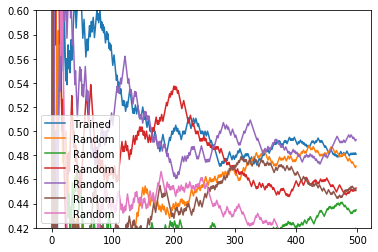

In [973]:
#plt.plot(losses)
wr_plots = plt.plot(np.array(wr)[:, :], label="abcdefg")
plt.legend(wr_plots, ["Trained"] + ["Random"]*6, loc=3)
plt.ylim(0.42, 0.6)
pass

In [14]:
class Elo(object):
    def __init__(self, bots):
        self.elos = dict(list((id(bot), 1600) for bot in bots))
    def add_bot(self, bot):
        if id(bot) not in self.elos:
            self.elos[id(bot)] = 1600
    def update_elo(self, game):
        losers = [p for p in game.players if p not in game.winners]
        winner_ids = list(map(id, game.winners))
        loser_ids = list(map(id, losers))
        
        m = sum(self.elos[w] for w in winner_ids) / len(winner_ids)
        o = sum(self.elos[l] for l in loser_ids) / len(loser_ids)
        
        delta = min(20, np.exp((o-m)/30))
        for w in winner_ids:
            self.elos[w] += delta * len(loser_ids) / 7
        for l in loser_ids:
            self.elos[l] -= delta * len(winner_ids) / 7
            
    def get_elos(self, bots):
        return [self.elos[id(bot)] for bot in bots]
        

In [975]:
bots = [RandomPlayer() for i in range(6)]
elo = Elo(bots)

In [976]:
def generation():
    for bot in bots:
        bot.wins = 0
        bot.games_played = 0
        
    training_games = 500
    new_bot = NNPlayer(lr=1e-2, r=0.99, do_random=1, random_decrease_rate=2/training_games)
    elo.add_bot(new_bot)

    losses = []
    wr = []
    elos = []
    avg_loss = 0

    load_bar = tqdm(range(1, training_games+1))
    for i in load_bar:
        players = [new_bot] + choice(bots, 6, replace=False).tolist()
        game = Game(players, verbose=0)
        game.play()
        elo.update_elo(game)
        loss = new_bot.train()
        avg_loss += loss
        losses.append(avg_loss/i)
        wr.append([p.wins/max(1, p.games_played) for p in [new_bot] + bots[:6]])
        elos.append(elo.get_elos([new_bot]+bots[:6]))
        s = '%s %.4f' % (' '.join(map(lambda x: '%.2f'%x, elos[-1][:3])), losses[-1]*1000)
        load_bar.set_description(s)
    
    return new_bot, elos, wr, losses

In [978]:
generations = 20
all_wrs = []
all_elos = []
all_losses = []
for g in range(generations):
    new_bot, elos, wr, losses = generation()
    bots = [new_bot] + bots
    all_elos.append(elos)
    all_wrs.append(wr)
    all_losses.append(losses)

KeyboardInterrupt: 

In [979]:
print(*elo.get_elos(bots), sep='\n')

1597.5910494854672
1599.431365072456
1605.7537584700274
1601.048925612217
1597.5146015494197
1593.8506692034598
1600.104554132344
1595.9600768290422
1606.042381442805
1599.0366208033247
1605.9153558200292
1598.5903191889158
1606.8272959161475
1598.8235000889294
1593.344573024721
1590.739807986798
1607.9039905090053
1592.785823446443
1599.6638778968859
1603.6228559627618


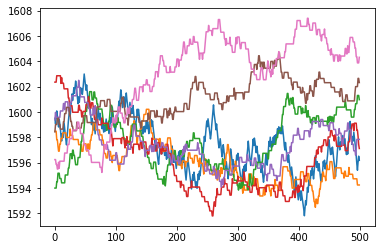

In [980]:
plt.plot(all_elos[-1])

In [823]:
players = choice(bots[:7], 7, replace=False)
print(bots[0].q)
game = Game(players, verbose=3)
print(bots[0].q)
game.play()

tensor([[[0.6635]]], device='cuda:0', grad_fn=<SigmoidBackward>)
Lib Fas Hit Fas Lib Lib Lib
tensor([[[0.6268]]], device='cuda:0', grad_fn=<SigmoidBackward>)
1 has chosen 3 as chancellor.
4 vote probs: [0.49893025 0.5010697 ]
Votes: Ja Ja Ja Nein Ja Ja Nein
Cabinet passes.
President (1) claims BRR (sees BRR)
Chancellor (3) claims RR (sees BR)
Fascist policy enacted.
Current tally: L0, F1
2 has chosen 7 as chancellor.
4 vote probs: [0.49895337 0.50104666]
Votes: Ja Nein Nein Nein Ja Ja Nein
Failed to pass.
3 has chosen 1 as chancellor.
4 vote probs: [0.4989609 0.501039 ]
Votes: Nein Nein Nein Nein Ja Ja Ja
Failed to pass.
4 chance pick probs: [0.14278194 0.14289373 0.14287564 0.14290822 0.14287312 0.14282776
 0.14283958]
4 has chosen 2 as chancellor.
4 vote probs: [0.49898535 0.5010147 ]
Votes: Ja Nein Nein Nein Nein Nein Nein
Failed to pass.
A fascist policy is top decked.
Current tally: L0, F2
5 has chosen 7 as chancellor.
4 vote probs: [0.4989192 0.5010808]
Votes: Nein Ja Ja Nein Ja 

In [200]:
new_bot, elos, wr, losses = generation()

c:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\python37\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\python37\lib\site-packages\ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\python37\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\python37\lib\site-packages\ipykernel_launcher.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\python37\lib\site-packages\ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for softmax has b

In [211]:
bots = [new_bot] + bots

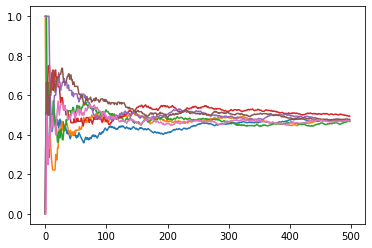

In [202]:
plt.plot(wr)

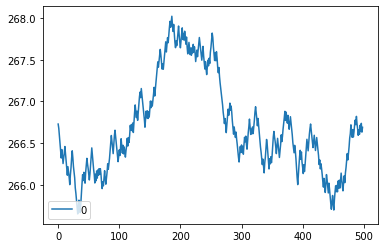

In [403]:
wr_plots = plt.plot(np.sum(np.array(elos)[:,:1], axis=1)/(len(elos[0])-1))
#plt.ylim(0.3, 0.6)
plt.legend(wr_plots, list(range(7)), loc=3)

In [19]:
bots = [RandomPlayer() for i in range(7)] + [RandomPlayerOld() for i in range(7)]
elo = Elo(bots)
elos = []
for i in range(10000):
    game = Game(choice(bots, 7, replace=False))
    game.play()
    elo.update_elo(game)
    elos.append(elo.get_elos(bots))
    if i%1000 == 0:
        print(i/1000)

0.0
50.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
450.0


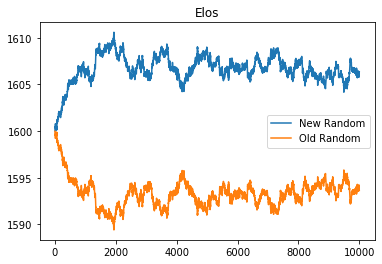

In [36]:
plt.plot(np.sum(np.array(elos)[:,:7], axis=1)/7, label="New Random")
plt.plot(np.sum(np.array(elos)[:,7:], axis=1)/7, label="Old Random")
plt.title("Elos")
plt.legend()